In [13]:
import pandas as pd
import numpy as np
from scipy import stats
from keras.layers import Lambda

input_dim=784
intermediate_dim=200
latent_dim=2

**Activation Classes**

In [14]:
class Activation_ReLU:
  def __init__(self):
    self.input=[]
    self.output=[]
    self.dinputs=[]

  def forward(self, input):
    self.input = input
    self.output=np.maximum(0, input)

  def backward(self, dvalues):
    dvalues = np.sum(dvalues, axis=0, keepdims=True)
    self.dinputs=dvalues*np.where(self.output > 0, 1, 0)

class Activation_Sigmoid:
  def __init__(self):
    self.input=[]
    self.output=[]
    self.dinputs=[]

  def forward(self, input):
    self.output = 1 / (1 + np.exp(-input))

  def backward(self, dvalues):
    self.dinputs = dvalues * (1 - self.output) * self.output

**Clase Encoder**

In [15]:
class Encoder:

  def __init__(self, input_dim, intermediate_dim, latent_dim):
    self.layer1=Dense(input_dim, intermediate_dim)
    self.layer1Activation=Activation_ReLU()
    self.z_mu=Dense(intermediate_dim, latent_dim)
    self.z_log_sigma2=Dense(intermediate_dim, latent_dim)
    self.z=[]

  def sample_z(self):
    epsilon = np.random.normal(0, 1, size=self.z_mu.output.shape)
    return self.z_mu.output + np.exp(self.z_log_sigma2.output*.5) * epsilon

  def encode(self, input):
    self.layer1.forward(input)
    self.layer1Activation.forward(self.layer1.output)

    self.z_mu.forward(self.layer1Activation.output)

    self.z_log_sigma2.forward(self.layer1Activation.output)

    self.z=self.sample_z();

    return self.z

**Clase Decoder**

In [16]:
class Decoder:
  def __init__(self, latent_dim, intermediate_dim, input_dim):
    self.layer1=Dense(latent_dim, intermediate_dim)
    self.layer1Activation=Activation_ReLU()
    self.layer2=Dense(intermediate_dim, input_dim)
    self.layer2Activation=Activation_Sigmoid()

  def decode(self, input):
    self.layer1.forward(input)
    self.layer1Activation.forward(self.layer1.output)


    self.layer2.forward(self.layer1Activation.output)
    self.layer2Activation.forward(self.layer2.output)

    return self.layer2Activation.output

**Clase Dense**

In [17]:
class Dense:
  def __init__(self, input_dim, neurons, weight_regularizer_l1=[0],
               weight_regularizer_l2=[0], bias_regularizer_l1=[0], bias_regularizer_l2=[0]):

    self.weights=0.1*np.random.randn(input_dim, neurons)
    self.biases=np.zeros((1, neurons))
    self.input=[]
    self.output=[]
    self.weight_regularizer_l1=np.array(weight_regularizer_l1)
    self.weight_regularizer_l2=np.array(weight_regularizer_l2)
    self.bias_regularizer_l1=np.array(bias_regularizer_l1)
    self.bias_regularizer_l2=np.array(bias_regularizer_l2)
    self.dweights=0
    self.dbiases=0
    self.dinputs=0

  def  forward(self, input):
    self.input=input
    self.output=np.dot(self.input, self.weights)+self.biases

  def backward(self, dvalues):
    self.dweights = np.dot(self.input.T, dvalues)
    self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

    if self.weight_regularizer_l1.any()>0:
      dL1=np.ones_like(self.weights)
      dL1[self.weights<0]=-1
      self.dweights += np.squeeze(self.weight_regularizer_l1 * dL1, axis=0)

    if self.weight_regularizer_l2.any()>0:
      self.dweights += 2 * np.squeeze(self.weight_regularizer_l2 * \
                       self.weights, axis=0)

    if self.bias_regularizer_l1.any() > 0:
      dL1 = np.ones_like(self.biases)
      dL1[self.biases < 0] = -1
      self.dbiases += self.bias_regularizer_l1 * dL1

    if self.bias_regularizer_l2.any() > 0:
      self.dbiases += 2 * self.bias_regularizer_l2 * \
                      self.biases

    self.dinputs = np.dot(dvalues, self.weights.T)

  def backward2(self, dvalues):
      self.dbiases=dvalues
      if self.input.shape[0]!=1:
         self.input=self.input.reshape(1, -1)
      self.dweights=np.dot(self.input.T,dvalues)
      self.dinputs=np.dot(dvalues, self.weights.T)



**Perdidas**

In [18]:
class Loss:
  def __init__(self):
    self.accumulated_sum=0
    self.accumulated_count=0

  def regularization_loss(self):
    regularization_loss = 0
    count=1
    for layer in self.trainable_layers:
      print(count)
      count+=1
      if layer.weight_regularizer_l1.any()>0:
        print("wrl1: ", layer.weight_regularizer_l1.shape)
        print("w: ", layer.weights.shape)
        regularization_loss += layer.weight_regularizer_l1 * \
                              np.sum(np.abs(layer.weights))
        print("rl: ", regularization_loss.shape)
      if layer.weight_regularizer_l2.any() > 0:
        regularization_loss += layer.weight_regularizer_l2 * \
                              np.sum(layer.weights * \
                                      layer.weights)

      if layer.bias_regularizer_l1.any() > 0:
        regularization_loss += layer.bias_regularizer_l1 * \
                              np.sum(np.abs(layer.biases))

      if layer.bias_regularizer_l2.any() > 0:
        regularization_loss += layer.bias_regularizer_l2 * \
                              np.sum(layer.biases * \
                                      layer.biases)
    return regularization_loss

  def remember_trainable_layers(self, trainable_layers):
    self.trainable_layers=trainable_layers

  def calculate(self, output, y, *, include_regularization = False):
    sample_losses=self.forward(output, y)
    data_loss = np.mean(sample_losses)

    self.accumulated_sum += np.sum(sample_losses)
    self.accumulated_count += len(sample_losses)

    if not include_regularization:
      return data_loss
    else:
      return data_loss, self.regularization_loss()

  def calculate_accumulated(self, *, include_regularization = False):
    data_loss = self.accumulated_sum / self.accumulated_count

    if not include_regularization:
      return data_loss
    else:
      return data_loss, self.regularization_loss()

  def new_pass(self):
    self.accumulated_sum = 0
    self.accumulated_count = 0

class LossBinaryCrossEntropy(Loss):
  def forward(self, y_pred, y_true):
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

    sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
    sample_losses = np.mean(sample_losses, axis=1)

    return sample_losses

  def backward(self, dvalues, y_true):
    samples = len(dvalues)
    outputs = len(dvalues[0])

    clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

    self.dinputs = -(y_true / clipped_dvalues - (1 - y_true)
                     /(1 - clipped_dvalues))/outputs

    self.dinputs = self.dinputs / samples


**Optimizador rmsprop**

In [175]:
class Rmsprop:
  def __init__(self, learning_rate=0.001, decay=0.01, epsilon=1e-8, rho=0.9):
    self.learning_rate = learning_rate
    self.current_learning_rate = learning_rate
    self.decay = decay
    self.iterations = 0
    self.epsilon = epsilon
    self.rho = rho

  def pre_update_params(self):
    if self.decay:
      self.current_learning_rate = self.learning_rate * \
          (1. / (1. + self.decay * self.iterations))

  def update_params(self, layer):
    if not hasattr(layer, 'wight_cache'):
      layer.weight_cache = np.zeros_like(layer.weights)
      layer.bias_cache = np.zeros_like(layer.biases)

    layer.weight_cache = self.rho * layer.weight_cache + \
        (1 - self.rho) * layer.dweights**2
    layer.bias_cache = self.rho * layer.bias_cache + \
        (1 - self.rho) * layer.dbiases**2

    layer.weights += -self.current_learning_rate * \
                    layer.dweights / \
                    (np.sqrt(layer.weight_cache) + self.epsilon)
    layer.biases += -self.current_learning_rate * \
                    layer.dbiases / \
                    (np.sqrt(layer.bias_cache) + self.epsilon)
    return layer

  def post_update_params(self):
    self.iterations += 1


**Importación del Dataset**

In [20]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype( 'float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape( (len(x_test),  np.prod(x_test.shape[1:])))

In [21]:
new_test=[x_test[3], x_test[15], x_test[6]]

**Clase VAE**

In [41]:
class VAE:
  def __init__(self, input_dim, intermediate_dim, latent_dim):
    self.encoder=Encoder(input_dim, intermediate_dim, latent_dim)
    self.decoder=Decoder(latent_dim, intermediate_dim, input_dim)
    self.optimizer=Rmsprop()
    self.binaryCrossEntropy=LossBinaryCrossEntropy()
    self.trainable_layers=[self.encoder.layer1, self.encoder.z_mu, self.encoder.z_log_sigma2,\
                        self.decoder.layer1, self.decoder.layer2]

    self.binaryCrossEntropy.remember_trainable_layers(self.trainable_layers)


  def predict(self, input):
    return self.decoder.decode(self.encoder.encode(input))

  #Funcio de perdida ELBO
  def ELBO(self, input, output):
      logP = len(input)*self.binaryCrossEntropy.forward(output, input)
    #D(Q(z|x)||P(z))
      Dk1 = 0.5 * np.sum(np.exp(self.encoder.z_log_sigma2.output)+np.square(self.encoder.z_mu.output)-1. - self.encoder.z_log_sigma2.output, axis=-1)
      logP=np.mean(logP)
      return np.mean(logP+Dk1)


  def backward(self, input, output):
    loss=output-input
    self.decoder.layer2Activation.backward(loss)
    self.decoder.layer2.backward2(self.decoder.layer2Activation.dinputs)
    self.decoder.layer1Activation.backward(self.decoder.layer2.dinputs)
    self.decoder.layer1.backward2(self.decoder.layer1Activation.dinputs)
    self.encoder.z_log_sigma2.backward2(self.decoder.layer1.dinputs)
    self.encoder.z_mu.backward2(self.decoder.layer1.dinputs)
    self.encoder.layer1Activation.backward(self.encoder.z_mu.dinputs)
    self.encoder.layer1.backward2(self.encoder.layer1Activation.dinputs)


  def fit(self, input, epochs=1, batch_size=None, validation_data=None):
    for epoch in range(1, epochs+1):
      print("Epoch: ", epoch)
      loss=0
      self.binaryCrossEntropy.new_pass()
      for data in input:
        output=self.predict(data)
        loss += self.ELBO(data, output)
        self.backward(data, output)
        self.optimizer.pre_update_params()
        for layer in self.trainable_layers:
          layer=self.optimizer.update_params(layer)
        self.optimizer.post_update_params()
      print("Loss: ", loss/len(input))
    print("train end")


**Pruebas durante realización**

In [181]:
import matplotlib.pyplot as plt
modelVAE=VAE(input_dim, intermediate_dim, latent_dim)
modelVAE.fit(input=x_train[0:3], epochs=140, batch_size=None, validation_data=None)

Epoch:  1
Loss:  537.8785650593428
Epoch:  2
Loss:  459.36338225523474
Epoch:  3
Loss:  355.00359312299844
Epoch:  4
Loss:  322.67900393080106
Epoch:  5
Loss:  281.8495985323041
Epoch:  6
Loss:  252.8128306341721
Epoch:  7
Loss:  230.32444248022458
Epoch:  8
Loss:  224.46234599058047
Epoch:  9
Loss:  213.90581999438754
Epoch:  10
Loss:  218.8036212739377
Epoch:  11
Loss:  209.0098771281786
Epoch:  12
Loss:  202.3508376335598
Epoch:  13
Loss:  185.60505171870776
Epoch:  14
Loss:  195.15493025747597
Epoch:  15
Loss:  177.45293632526503
Epoch:  16
Loss:  206.22748733936373
Epoch:  17
Loss:  169.99926056464355
Epoch:  18
Loss:  174.32090668069478
Epoch:  19
Loss:  181.19778553023977
Epoch:  20
Loss:  149.92786928382978
Epoch:  21
Loss:  176.02982882593463
Epoch:  22
Loss:  146.85149278466716
Epoch:  23
Loss:  202.8167570419641
Epoch:  24
Loss:  136.2724854497588
Epoch:  25
Loss:  152.10548007363067
Epoch:  26
Loss:  136.3769391315839
Epoch:  27
Loss:  136.34260675670234
Epoch:  28
Loss:  1

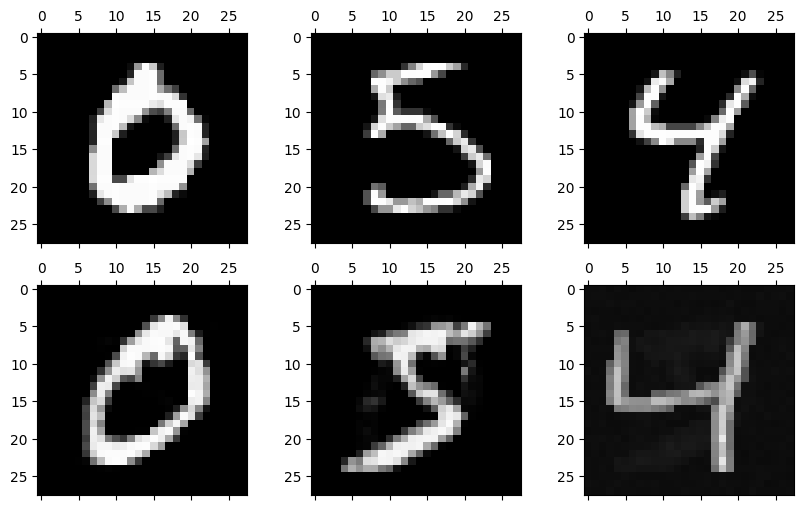

In [182]:
fig, ax = plt.subplots(2,3, figsize = (10, 6))

for i in range(len(new_test)): #Probamos con 3 imagenes del congunto de test
    img=new_test[i][None,:]
    out_img = modelVAE.predict(img)
    ax[0,i].matshow(img.reshape((28,28)),  cmap='gray', clim=(0,1))
    ax[1,i].matshow(out_img.reshape((28,28)), cmap='gray', clim=(0,1))
pass